In [1]:
import cv2
import math
import numpy as np
import torch

import os
from collections import OrderedDict
import matplotlib.pyplot as plt
from datetime import datetime

from glob import glob

In [2]:
# calulate SSIM

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

# calculate PSNR

def calc_psnr(img1, img2):
    # input: img1 (img2) 
    #   torch.Tensor, range in [0, 1.0]
    img1, img2 = img1 * 255.0, img2 * 255.0
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(255.0 / torch.sqrt(mse))

In [17]:
# CHANGE HERE TO CONDUCT EACH EXPERIMENT

GLOBAL_SIGMA = 25
ARCH = 'ignetp'
EVAL_DATASET = 'Set12' # 'BSD68' 'Urban100'

In [18]:
import importlib
import sys
sys.path.append('..')
config = getattr(importlib.import_module(f"configs.config_{ARCH}_sigma{GLOBAL_SIGMA}"), 'get_config')()

In [19]:
config.eval_dir = f'./eval_dataset_images/{EVAL_DATASET}'
config.__dict__

{'seed': 2021,
 'train_dir': '/home/jzsherlock/my_lab/r_proj/_0_pause/IDN/datasets/MWCNN_Trainset_YChannel',
 'eval_dir': './eval_dataset_images/Set12',
 'patch_size': 128,
 'stride': 2000,
 'sigma': 25,
 'aug_flip_times': 1,
 'aug_scales': [1],
 'num_workers': 16,
 'use_gpus': [0, 1, 2, 3],
 'model_arch': 'ignetp',
 'model_params': {'in_ch': 1, 'out_ch': 1, 'base_ft': 64, 'mid_ft': 32},
 'output_dir': '../output',
 'batch_size': 64,
 'num_epochs': 100,
 'lr': 0.001,
 'vis_dir': '../pred_vis/arch_ignetp_bs64_lr0.001_p128_s2000_sigma25_augf1_augs1',
 'vis_interval': 1,
 'exp_name': 'arch_ignetp_bs64_lr0.001_p128_s2000_sigma25_augf1_augs1'}

In [20]:
from dataloader_train400 import get_eval_dataloader
eval_dataloader, len_evalset = get_eval_dataloader(config)
print(len_evalset)
for idx, data in enumerate(eval_dataloader):
    if idx > 2:
        break
    print('{}th eval batch'.format(idx))
    print(data[0].size(), data[1].size())

./eval_dataset_h5/Set12_SIGMA25.h5 already generated, use this file as eval dataset
12
0th eval batch
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
1th eval batch
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
2th eval batch
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


In [21]:
device = 'cuda'

best_psnr = 0
best_ssim = 0

from archs.ignet import IGNet
network = IGNet(**config.model_params).cuda()

network.eval()
# print(network)

ckpt_path = f'./ckpts/{config.model_arch}_sigma{GLOBAL_SIGMA}/best.pth'
print(ckpt_path)

state_dict = torch.load(ckpt_path, map_location=torch.device('cuda'))
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove 'module.'
    new_state_dict[name] = v 
# reload params
network.load_state_dict(new_state_dict)

avg_psnr = 0
avg_ssim = 0
network.eval()
for imid, data in enumerate(eval_dataloader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    inputs, labels = inputs.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)

    with torch.no_grad():
        preds = network(inputs)[0].clamp(0.0, 1.0)
        psnr = calc_psnr(preds, labels)
        avg_psnr += psnr
        ssim_value = calculate_ssim(preds.detach().cpu().numpy()[0,0] * 255.0,\
                              labels.detach().cpu().numpy()[0,0] * 255.0)
        avg_ssim += ssim_value

print(f'avg psnr: {(avg_psnr / len(eval_dataloader)).item():.4f} avg ssim: {(avg_ssim / len(eval_dataloader)).item():.4f}')

./ckpts/ignetp_sigma25/best.pth
avg psnr: 30.7159 avg ssim: 0.8688


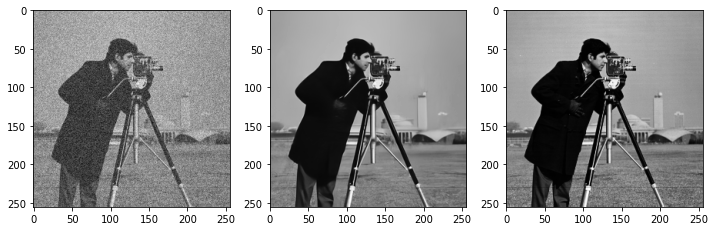

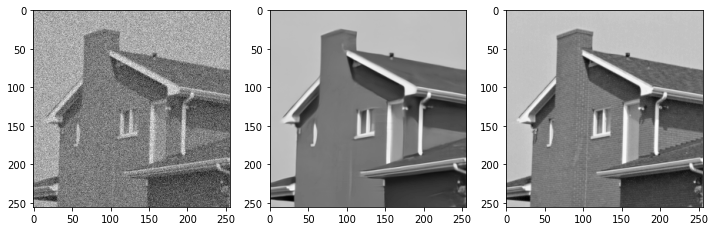

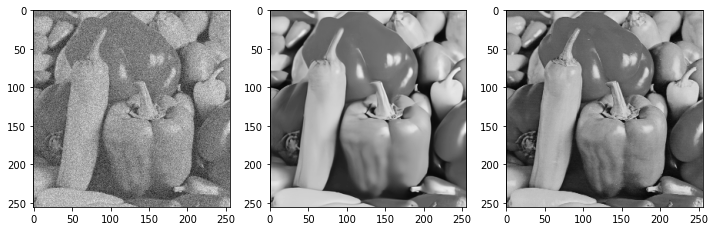

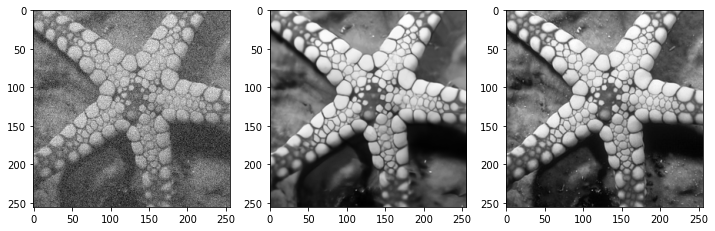

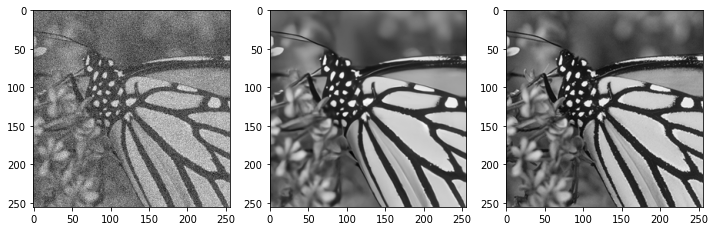

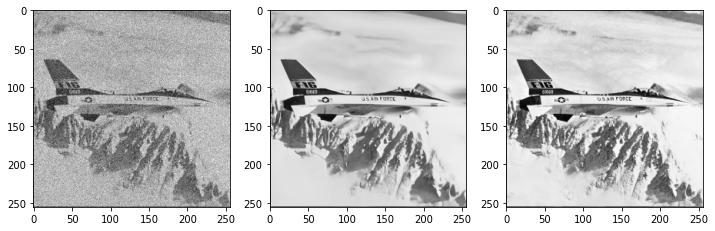

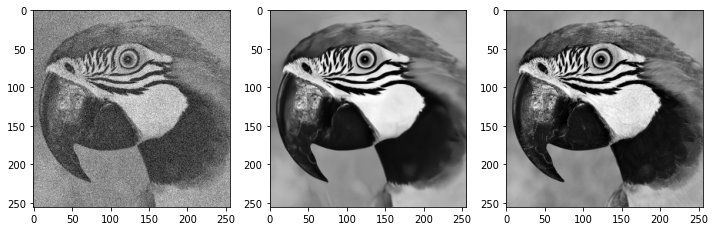

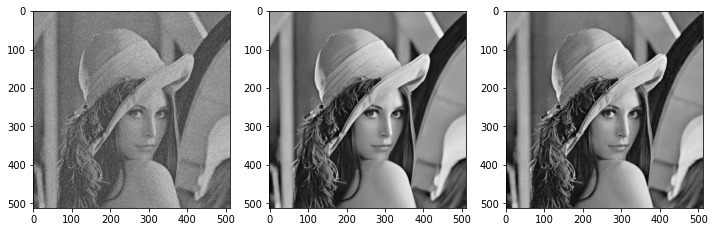

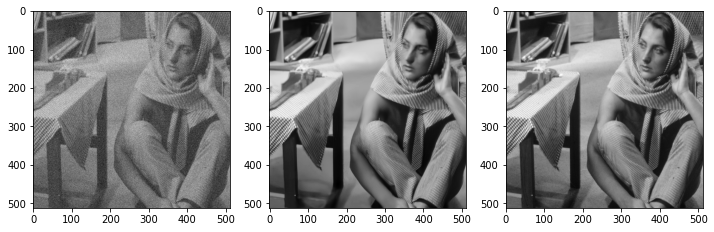

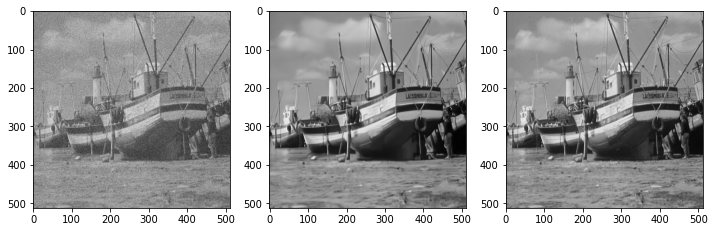

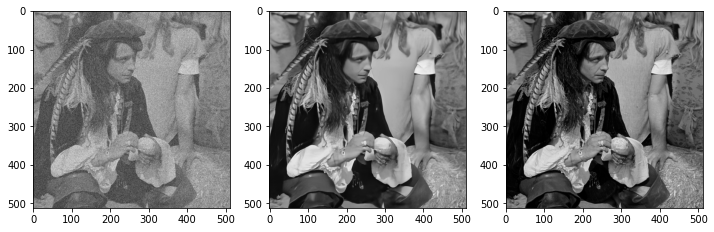

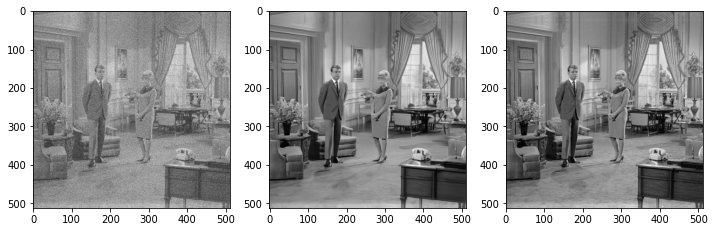

In [22]:
SHOW_NUM = 12

for imid, data in enumerate(eval_dataloader):
    
    if imid >= SHOW_NUM:
        break
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    inputs, labels = inputs.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)

    with torch.no_grad():
        preds = network(inputs)[0].clamp(0.0, 1.0)
        
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(inputs.detach().cpu().numpy()[0,0], cmap='gray')
    plt.subplot(132)
    plt.imshow(preds.detach().cpu().numpy()[0,0], cmap='gray')
    plt.subplot(133)
    plt.imshow(labels.detach().cpu().numpy()[0,0], cmap='gray')